In [0]:
import numpy as np
import matplotlib.pyplot as plt

# functions for physics of the problem

# rotation matrix: body frame --> inertial frame
def rotation(Theta):
    phi=Theta[0][0]
    theta=Theta[1][0]
    psi=Theta[2][0]
    
    R = np.array([[np.cos(psi)*np.cos(theta),np.cos(psi)*np.sin(theta)*np.sin(phi)-np.sin(psi)*np.cos(phi),np.cos(psi)*np.sin(theta)*np.cos(phi)+np.sin(psi)*np.sin(phi)],
                 [np.sin(psi)*np.cos(theta),np.sin(psi)*np.sin(theta)*np.sin(phi)+np.cos(psi)*np.cos(phi),np.sin(psi)*np.sin(theta)*np.cos(phi)-np.cos(psi)*np.sin(phi)],
                 [-np.sin(theta),np.cos(theta)*np.sin(phi),np.cos(theta)*np.cos(phi)]])
    
    return R


# Thetadot2omega gives the angular velocity vector, omega, from the time derivatives of roll, pitch, yaw
def Thetadot2omega(Thetadot, Theta):
    phi=Theta[0][0]
    theta=Theta[1][0]
    psi=Theta[2][0]
    omegaarray = np.array([[1, 0, -np.sin(theta)],
                          [0, np.cos(phi), np.cos(theta)*np.sin(phi)],
                          [0, -np.sin(phi),np.cos(theta)*np.cos(phi)]])
    omega = np.matmul(omegaarray,Thetadot)
    
    return omega


# omega2Thetadot gives the time derivatives of roll, ptich, and yaw (phi, theta, and psi) from the angular velocity vector
def omega2Thetadot(omega,Theta):
    phi=Theta[0][0]
    theta=Theta[1][0]
    psi=Theta[2][0]
    
    arr = np.array([[1, np.sin(phi)*np.tan(theta),  np.cos(phi)*np.tan(theta)], 
                    [0, np.cos(phi),  -np.sin(phi)],
                    [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])    
    Thetadot = np.matmul(arr,omega)

    return Thetadot

# calculate thrust given constant k (thrust coefficient) and angular velocities of rotors
def thrust(rotvsq,k):
    # omegasq are values for ω^2!
    
    T = np.array([[0],[0],[k*np.sum(rotvsq)]])
    return T

# compute torques given current inputs, length, drag coeff, and thrust coeff
def torques(rotvsq, L, b, k):
    #  omegasq are values for ω^2!
    tau = np.array([[L*k*(rotvsq[0]-rotvsq[2])],[L*k*(rotvsq[1]-rotvsq[3])],[b*(rotvsq[0]-rotvsq[1]+rotvsq[2]-rotvsq[3])]])
    return tau


# compute acceleration 
def acc(rotvsq,Theta,Xdot,m,g,k,kd):
    gravity = np.array([[0],[0],[-g]])
    R = rotation(Theta)
    T = np.matmul(R,thrust(rotvsq,k))
    Fd = -kd*np.power(Xdot,2)
    a = gravity+(1/m)*np.add(T,Fd)
    return a

# angular acceleration

def angular_acc(rotvsq,omega, I, L, b,k):
    tau = torques(rotvsq,L,b,k)
    invI = np.linalg.inv(I)
    omegadot = np.matmul(invI, np.subtract(tau,np.cross(omega, np.matmul(I,omega),axis=0)))

    return omegadot

# physical constants, parameters, etc
Ixx = 4.856e-3 # kg*m2
Iyy = 4.856e-3 # kg*m2
Izz = 8.801e-3 # kg*m2
I = np.array([[Ixx,0,0],[0,Iyy,0],[0,0,Izz]])

g = 9.81; # acceleration due to gravity (m/s2)
m = .468 # kg
L = .225 # m

k = 2.98e-6 # thrust coefficient
b = 1.14e-7 # drag coefficient
kd = 0.055 # drag, kg/s

# integrated PD controller
# calculate required values dx, dy, dz in equation 26


# PD CONTROL - angular torques

# find torques given commmanded angle values defined above

def calc_torques(controlang,Thetadot,Thetacprev):
    KphiP = 1.3
    KphiD = 2
    KthetaP = 1.3
    KthetaD = 2
    KpsiP = 1.3
    KpsiD = 2
    
    phic = controlang[0]
    thetac = controlang[1]
    psic = controlang[2]
    
    phi = Theta[0]
    theta = Theta[1]
    psi = Theta[2]
    
    phidot = Thetadot[0]
    thetadot = Thetadot[1]
    psidot = Thetadot[2]
    
    phicprev = Thetacprev[0]
    phicprev = phicprev[0]
    thetacprev = Thetacprev[1]
    thetacprev = thetacprev[0]
    psicprev = Thetacprev[2]
    psicprev = psicprev[0]
    
    phidotc = (phic-phicprev)/dt
    thetadotc = (thetac-thetacprev)/dt
    psidotc = (psic-psicprev)/dt
    
    tauphi = (KphiP*(phic-phi)+KphiD*(phidotc-phidot))*I[0][0]
    tautheta = (KthetaP*(thetac-theta)+KthetaD*(thetadotc-thetadot))*I[1][1]
    taupsi = (KpsiP*(psic-psi)+KpsiD*(psidotc-psidot))*I[2][2]
    
    phic = phicprev
    thetac = thetacprev
    psic = psicprev
    Thetacprev = [[phicprev],[thetacprev],[psicprev]]
    
    tauTheta = [[tauphi],[tautheta],[taupsi]]
    
    return tauTheta, Thetacprev
  
# Calculate the angular velocity for each rotor  
def rotorangv_stab(tauTheta,k,L,b,T):
  rotvsq_stab=np.zeros((4,1))
  tauphi=tauTheta[0][0]
  tauphi=tauphi[0]
  tautheta=tauTheta[0][1]
  tautheta=tautheta[0]
  taupsi=tauTheta[0][2]
  taupsi=taupsi[0]  
  
  #tauTheta = calc_torques(controlang,Thetadot,Thetacprev)[0] ###
  rotvsq_stab[3,0]=(T/(4*k))-(tautheta/(2*k*L))-(taupsi/(4*b))
  rotvsq_stab[2,0]=(T/(4*k))-tauphi/(2*k*L)+taupsi/(4*b)
  rotvsq_stab[1,0]=(T/(4*k))+tautheta/(2*k*L)-taupsi/(4*b)
  rotvsq_stab[0,0]=(T/(4*k))+tauphi/(2*k*L)+taupsi/(4*b)
  return rotvsq_stab

# PD CONTROL - thrust
def T_stabilize(g,Xdotd,Xdot,m,Theta,X,Xd):
  KzD = 4.5
  KzP=5
  phi=Theta[0][0]
  theta=Theta[1][0]
  xdotD=Xdotd[2]
  xdot=Xdot[2]
  xd=Xd[2]
  x=X[2]
  T_stab=(g+KzD*(xdotD[0]-xdot[0])+KzP*(xd[0]-x[0]))*m/(np.cos(phi)*np.cos(theta))
  return T_stab

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


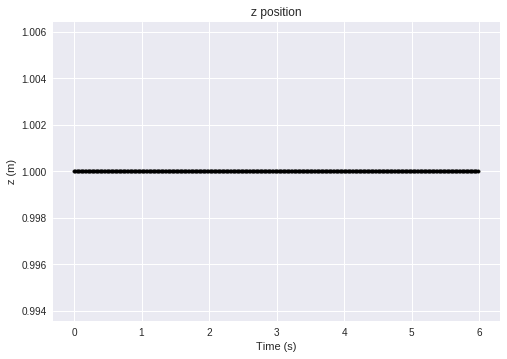

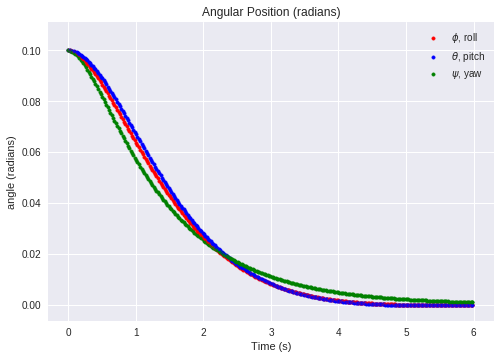

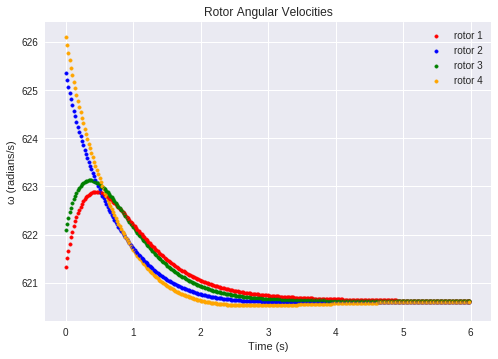

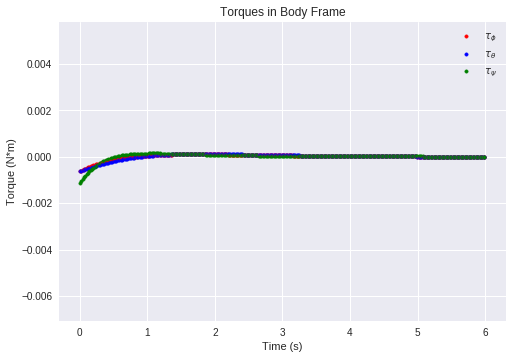

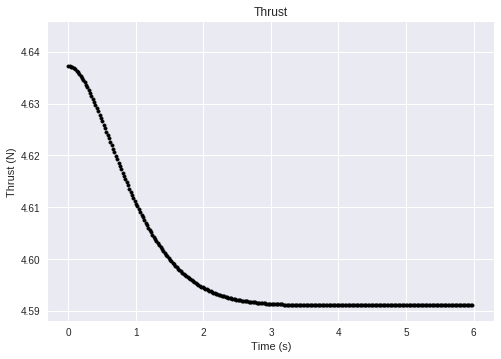

In [0]:
# Stabilization

# Inputs
Theta=[[.1],[.1],[.1]]   #Set initial roll, pitch, and yaw in radians (0 - 1.5)
Start_height = 1         #Set starting height in meters
End_height = 1           #Set desired height in meters


# Set initial parameters

X=[[0],[0],[Start_height]]
Xd=[[0],[0],[End_height]]
Xdotd=np.zeros((3,1))
Xdot=np.zeros((3,1))
Thetadot=np.zeros((3,1))
phidot = Thetadot[0]
thetadot = Thetadot[1]
psidot = Thetadot[2]
Thetacprev=np.zeros((3,1))

# Time loop
start_time = 0
end_time = 6
dt = .02
times = np.linspace(start_time,end_time,num=(end_time/dt))

rotvsq = np.zeros((4,1))


plt.figure(1)

# for angles on same plot
fig = plt.figure(2)
ax1 = fig.add_subplot(111)

# rotor angular velocities on same plot
fig2 = plt.figure(3)
ax2 = fig2.add_subplot(111)

# torque outputs on same plot
fig3 = plt.figure(4)
ax3 = fig3.add_subplot(111)


for i in range(0,len(times)-1):
    # plot values relevant to position of quadcopter - angles and z position
    plt.figure(1)
    plt.scatter(times[i],X[2],marker='.',color='black')
    
    plt.title('z position')
    plt.xlabel('Time (s)')
    plt.ylabel('z (m)')
    #plt.figure(2)
    
    
    # for angles on same plot
    ax1.scatter(times[i],Theta[0],marker='.',color='red')
    ax1.scatter(times[i],Theta[1],marker='.',color='blue')
    ax1.scatter(times[i],Theta[2],marker='.',color='green')
    
  
    # CONTROL
    # calculate thrust required to stabilize quadcopter at z setpoint (PD control)
    T_stab=T_stabilize(g,Xdotd,Xdot,m,Theta,X,Xd)
    
    # set desired angles to be zero
    controlang=np.zeros((3,1))
    
    # calculate omega - the time derivatives of roll, ptich, and yaw (phi, theta, and psi) - given the angular velocity vector (thetadot)
    omega = Thetadot2omega(Thetadot,Theta)
    
    # calculate the angular torques needed to stabilize given desired angles, angular velocity vector - PD control
    tauTheta=calc_torques(controlang,Thetadot,Thetacprev)
    # record previous desired angles in order to calculate desired angular velocities (more relevant for trajectory control)
    Thetacprev = calc_torques(controlang,Thetadot,Thetacprev)[1]
    
   
    # given calculated torques and thrust required to stabilize the quadcopter, calculate the inputs - the squares of the angular velocities of the rotors
    rotvsq_stab = rotorangv_stab(tauTheta,k,L,b,T_stab)
        
    # Plot Thrust
    plt.figure(5)
    plt.scatter(times[i],T_stab,marker='.',color='black')
    plt.title('Thrust')
    plt.xlabel('Time (s)')
    plt.ylabel('Thrust (N)')
    
    
    # rotor angular velocities on same plot
    ax2.scatter(times[i],rotvsq_stab[0]**.5,marker='.',color='red')
    ax2.scatter(times[i],rotvsq_stab[1]**.5,marker='.',color='blue')
    ax2.scatter(times[i],rotvsq_stab[2]**.5,marker='.',color='green')
    ax2.scatter(times[i],rotvsq_stab[3]**.5,marker='.',color='orange')
    
    # torque outputs on same plot
    
    ax3.scatter(times[i],tauTheta[0][0],marker='.',color='red')
    ax3.scatter(times[i],tauTheta[0][1],marker='.',color='blue')
    ax3.scatter(times[i],tauTheta[0][2],marker='.',color='green')
    
    
    # PHYSICS SIMULATION
    # calculate acceleration
    a = acc(rotvsq_stab,Theta,Xdot,m,g,k,kd)
    
    # calculate time derivative of angular velocity vector
    omegadot = angular_acc(rotvsq_stab,omega,I,L,b,k)  

    # update angular velocity vector
    omega[0][0] = omega[0][0] + dt * omegadot[0][0]
    omega[1][0] = omega[1][0] + dt * omegadot[1][0]
    omega[2][0] = omega[2][0] + dt * omegadot[2][0]
    
    # calculate angular velocities given angular velocity vector
    Thetadot = omega2Thetadot(omega, Theta)

    # update angles using angular velocities
    Theta[0][0] = Theta[0][0] + dt*Thetadot[0][0]
    Theta[1][0] = Theta[1][0] + dt*Thetadot[1][0]
    Theta[2][0] = Theta[2][0] + dt*Thetadot[2][0]
    
    
    # update linear velocities using acceleration calculated above
    Xdot[0][0] = Xdot[0][0] + dt*a[0][0]
    Xdot[1][0] = Xdot[1][0] + dt*a[1][0]
    Xdot[2][0] = Xdot[2][0] + dt*a[2][0]
    
    # update linear positions using linear velocities
    X[0][0] = X[0][0] + dt*Xdot[0][0]
    X[1][0] = X[1][0] + dt*Xdot[1][0]
    X[2][0] = X[2][0] + dt*Xdot[2][0]
    
    
# show all the plots
# add legend to angle plot
ax1.scatter(times[i],Theta[0],marker='.',color='red',label='$\phi$, roll')
ax1.scatter(times[i],Theta[1],marker='.',color='blue',label='$\\theta$, pitch')
ax1.scatter(times[i],Theta[2],marker='.',color='green',label='$\psi$, yaw')
plt.figure(2)
plt.legend(loc='upper right')
plt.title('Angular Position (radians)')
plt.xlabel('Time (s)')
plt.ylabel('angle (radians)')




ax2.scatter(times[i],rotvsq_stab[0]**.5,marker='.',color='red',label='rotor 1')
ax2.scatter(times[i],rotvsq_stab[1]**.5,marker='.',color='blue',label='rotor 2')
ax2.scatter(times[i],rotvsq_stab[2]**.5,marker='.',color='green',label='rotor 3')
ax2.scatter(times[i],rotvsq_stab[3]**.5,marker='.',color='orange',label='rotor 4')
plt.figure(3)
plt.legend(loc='upper right')
plt.title('Rotor Angular Velocities')
plt.xlabel('Time (s)')
plt.ylabel('ω (radians/s)')

ax3.scatter(times[i],tauTheta[0][0],marker='.',color='red',label='$\\tau_{\phi}$')
ax3.scatter(times[i],tauTheta[0][1],marker='.',color='blue',label='$\\tau_{\\theta}$')
ax3.scatter(times[i],tauTheta[0][2],marker='.',color='green',label='$\\tau_{\psi}$')
plt.figure(4)
plt.legend(loc='upper right')
plt.title('Torques in Body Frame')
plt.xlabel('Time (s)')
plt.ylabel('Torque (N*m)')



plt.show()

In [0]:
max(rotvsq_stab)

array([385170.55386767])